## Importando Bibliotecas

In [1]:
# Bibliotecas para tratar os dados
import pandas as pd
import numpy as np
from dtype_diet import report_on_dataframe, optimize_dtypes

# Bibliotecas para EDA
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly.express as px

# Biblioteca para manipular manipular diferentes partes do ambiente de tempo de execução do Python
import sys

# Biblioteca para manipular o sistema operacional
import os

# Adicionando o caminho na variavel ambiente de todas as coisas que são refatoradas
sys.path.append(os.getenv('PATH_SRC'))

# Bibliotecas para contrução do modelo
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

# Configurando para não exibir warnings
import warnings
warnings.filterwarnings("ignore")

# Importando funções criadas
import config, custom_funcs

## Importando o dataset

In [2]:
data = pd.read_csv(config.german_credit)

data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
# data['Risk'] = np.where(data['Risk']=='bad', 1, 0)
data.drop(columns='Unnamed: 0', inplace=True)

data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


##### Otimizando os tipos de colunas
Em um dataset com uma grande quantidade de dados, utilizar o tipo correto em cada coluna pode trazer ganhos no processamento do arquivo, gerando ganho de memória.

No projeto em questão, o dataset é pequeno então não teremos tanto problema com memória, mas utilizarei uma biblioteca que confere e altera para o melhor tipo de cada coluna

In [4]:
report_on_dataframe(data)

,Current dtype,Proposed dtype,Current Memory (MB),Proposed Memory (MB),Ram Usage Improvement (MB),Ram Usage Improvement (%)
Column,,,,,,
Age,int64,int8,3.970703,0.552734,3.417969,86.079685
Sex,object,category,26.246094,0.658203,25.587891,97.492186
Job,int64,int8,3.970703,0.552734,3.417969,86.079685
Housing,object,category,25.595215,0.682617,24.912598,97.333028
Saving accounts,object,category,25.041504,0.746094,24.295410,97.020571
Checking account,object,category,22.696289,0.686035,22.010254,96.977325
Credit amount,int64,int16,3.970703,1.041016,2.929688,73.782587
Duration,int64,int8,3.970703,0.552734,3.417969,86.079685
Purpose,object,category,28.169434,0.933594,27.235840,96.685792


In [5]:
optimize = report_on_dataframe(data, unit='MB')

data_optimize = optimize_dtypes(data, optimize)

print(f'Memória original: {data.memory_usage(deep=True).sum()/1024/1024} MB')
print(f'Memória otimizada: {data_optimize.memory_usage(deep=True).sum()/1024/1024} MB')

Memória original: 0.32978153228759766 MB
Memória otimizada: 0.012660980224609375 MB


In [6]:
data = data_optimize.copy()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               1000 non-null   int8    
 1   Sex               1000 non-null   category
 2   Job               1000 non-null   int8    
 3   Housing           1000 non-null   category
 4   Saving accounts   817 non-null    category
 5   Checking account  606 non-null    category
 6   Credit amount     1000 non-null   int16   
 7   Duration          1000 non-null   int8    
 8   Purpose           1000 non-null   category
 9   Risk              1000 non-null   category
dtypes: category(6), int16(1), int8(3)
memory usage: 11.9 KB


In [8]:
print(f'O dataframe possui {data.shape[0]} linhas e {data.shape[1]} colunas.')

O dataframe possui 1000 linhas e 10 colunas.


In [9]:
for c in data.columns:
    qtde = data[c].isnull().sum()
    if qtde != 0:
        print(f'A coluna {c} possui {qtde} campos nulos, representando {(qtde/data.shape[0])*100}% do total')

A coluna Saving accounts possui 183 campos nulos, representando 18.3% do total
A coluna Checking account possui 394 campos nulos, representando 39.4% do total


In [10]:
numeric_columns = data.drop(columns='Risk').select_dtypes(include=[np.number]).columns
categorical_columns = data.drop(columns='Risk').select_dtypes(exclude=[np.number]).columns

print(f'A dataset possui {len(numeric_columns)} colunas numéricas e {len(categorical_columns)} colunas não-numéricas')

A dataset possui 4 colunas numéricas e 5 colunas não-numéricas


In [11]:
data.nunique().sort_values()

Sex                   2
Risk                  2
Housing               3
Checking account      3
Job                   4
Saving accounts       4
Purpose               8
Duration             33
Age                  53
Credit amount       921
dtype: int64

No entanto ao comparar os dados com a descrição do conjunto, percebemos que a feature Job está como numérica, mas cada número correspondente a uma categoria.
O que é validado na contagem de valores unicos, onde a feature Job, possui apenas 4 valores únicos.

## EDA (Exploratory Data Analysis)

##### Antes de começar a analisar algumas hipóteses, será feito análises univariadas, para entender o público do estudo e verificar possíveis anomalias.

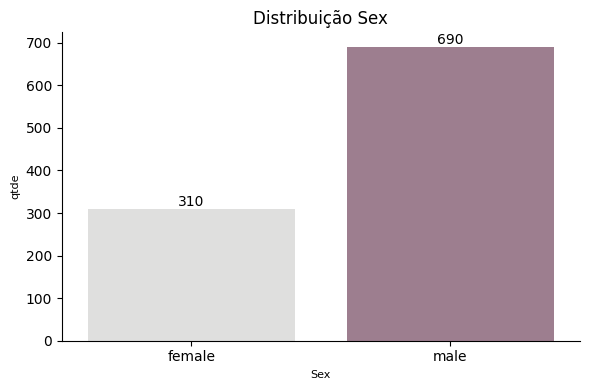

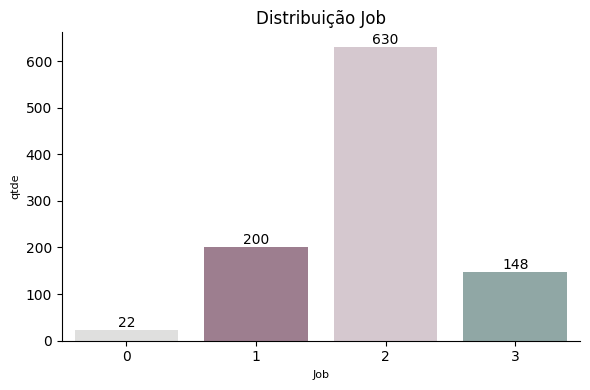

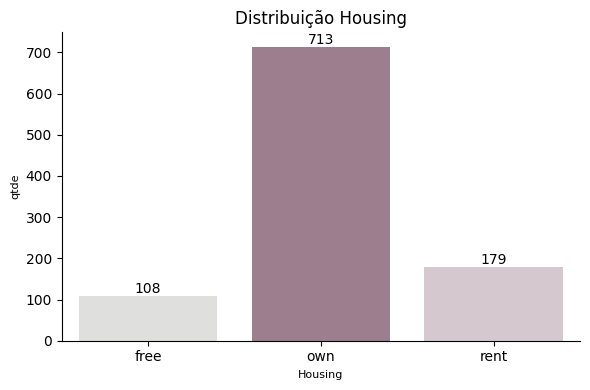

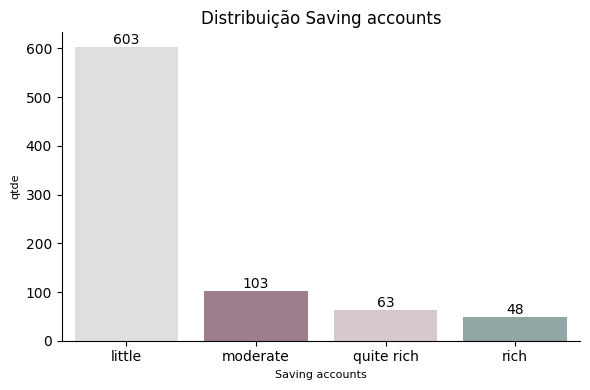

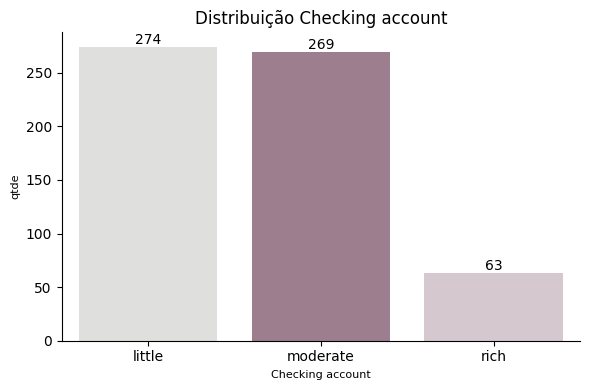

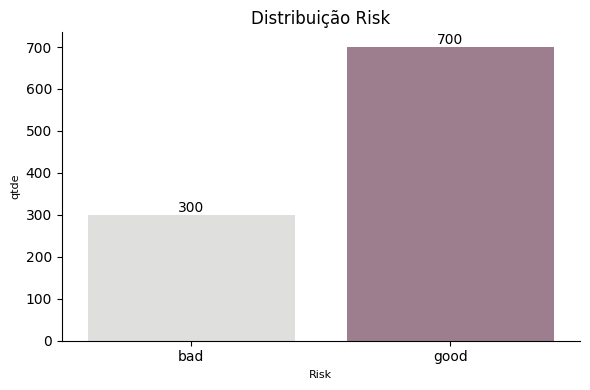

In [12]:
for columns in data.columns:
    if data[columns].nunique() <= 5:
        custom_funcs.grafico_barras(data[columns], columns)

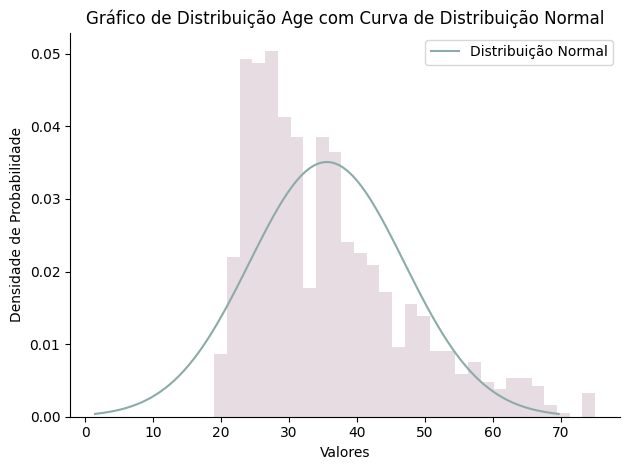

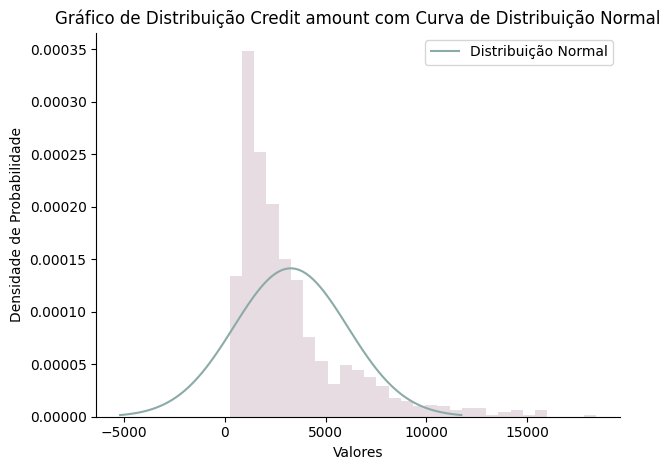

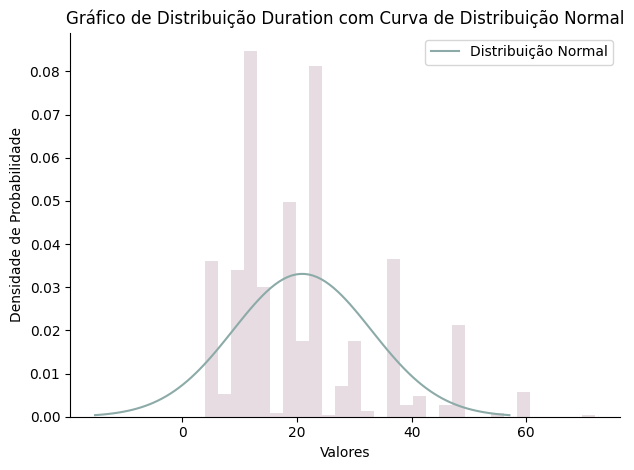

In [13]:
numerical = ['Age', 'Credit amount', 'Duration']

for c in numerical:
    custom_funcs.grafico_distribuicao(data[c])

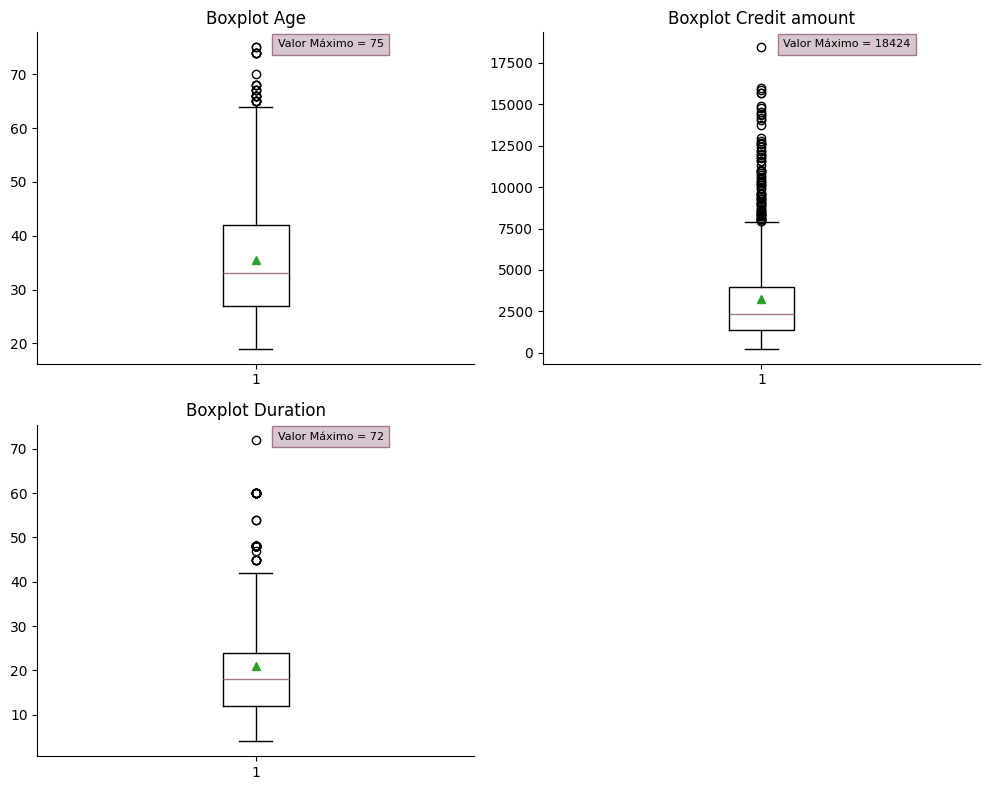

In [14]:
custom_funcs.grafico_bloxpot(numerical, data)

In [15]:
data[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0


Percebemos a presença de outliers nas três features, mas tendo uma maior ocorrência na feature 'Credit amount'. \
A média e a mediana da feature 'Credit amount' são bem distintas, e o desvio padrão alto. \
Em relação a distribuição, comparada com a curva normal, percebe-se que todas as três features não estão distribuidas de acordo com a distribuição normal.

Com base nas estatísticas geradas, a média da idade das pessoas do dataset é de 35 anos, com um limite de crédito médio de $3.271,26 e duração média de 21 meses. \
No entanto, os desvios padrões são consideráveis, principalmente no limite de crédito ($2.882,74), indicando uma grande variação dos dados. Percebemos a mediana do limite de crédito em $2.319,5 enquanto o valor máximo de crédito é de $18.424,0. Além disso, a diferença entre os valores dos quartis superior e inferior (intervalo interquartílico) é de $2.606,75 (3.972,25 - 1.365,5), mostrando que 50% dos dados estão espalhados nesse intervalo.




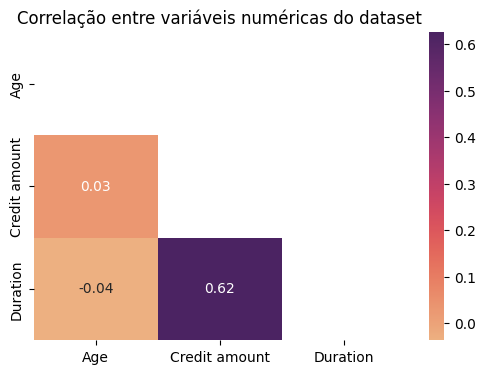

In [19]:
corr = data[['Age', 'Credit amount', 'Duration']].corr()

plt.figure(figsize=(6,4))

matrix = np.triu(corr)

sns.heatmap(corr, 
            annot=True,
            fmt = '.2f',
            cmap= 'flare',
            mask=matrix)

plt.title('Correlação entre variáveis numéricas do dataset') 
plt.show()

In [17]:
contagem_purpose = data['Purpose'].value_counts()

porcentagem_purpose = (contagem_purpose / len(data)) * 100

resultado = pd.DataFrame({'Contagem': contagem_purpose, 'Porcentagem': porcentagem_purpose})

print(resultado)

                     Contagem  Porcentagem
Purpose                                   
car                       337         33.7
radio/TV                  280         28.0
furniture/equipment       181         18.1
business                   97          9.7
education                  59          5.9
repairs                    22          2.2
domestic appliances        12          1.2
vacation/others            12          1.2


##### Seguiremos para uma análise bivariada, onde tentaremos entender a relação entre as váriaveis, como a váriavel alvo se comporta em cada feature e tentaremos responder algumas hipoteses sobre os dados.

- Qual gênero tem o maior % de bad risk? 
- Pessoas que possuem mais tempo possuem um valor de crédito maior? 
- Pessoas mais velhas possuem um valor de crédito maior?


In [18]:
resultado = data.groupby('Sex')['Risk'].value_counts().unstack(fill_value=0)
resultado_perc = data.groupby('Sex')['Risk'].value_counts(normalize=True).unstack(fill_value=0) *100

resultado


Risk,bad,good
Sex,,
female,109,201
male,191,499


In [19]:
resultado_perc

Risk,bad,good
Sex,,
female,35.161290,64.838710
male,27.681159,72.318841


In [53]:
data_graph = data[['Sex', 'Credit amount', 'Risk']]
data_graph['Sex_Risk'] = pd.concat([data_graph['Sex'], data_graph['Risk']], axis=1).apply(' '.join, axis=1)


fig = px.box(data_graph,
             x='Sex_Risk',
             y='Credit amount',
             color='Sex_Risk',
             color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_layout(
    xaxis=dict(title='Sex'),
    yaxis=dict(title='Credit Amount'),
    title="Credit Amount per Sex and Risk",
    showlegend=True
)

fig.show()


A partir desse boxplot da variação do Credit Amount pela junção das categorias Sex e Risk, conseguimos tirar alguns insights:
- A mediana em ambos os sexos e riscos não possuem muita variancia, a menor mediana está na categoria female good ($1.927) e maior mediana em male bad ($2.820)
- É possivel notar um padrão nos gráficos. Em ambos os sexos, quando classificados com risco bom, a variancia de 50% dos dados é menor do que em comparação a quando classificados com risco ruim.
    - O intervalo interquartil do male good é baixo ($2.432,25), mostrando pouca variancia em 50% dos dados, no entanto, vemos uma grande quantidade de outliers presentes nessa categoria. Já no male bad vemos um valor alto para o intervalo interquartil ($4.632,25), mostrando alta variancia em 50% dos dados.
- O maior valor de credito ($18.424) está em uma pessoa do sexo feminino com um risco ruim para o banco. Nessa mesma categoria, vemos que 25% das pessoas possuem um valor de crédito maior que $4.383,75, mesmo possuindo um risco ruim. Enquanto no risco bom, 75% das pessoas possuem um valor de crédito de até $3.457,25. O mesmo padrão conseguimos observar no sexo masculino, 75% das pessoas no risco bom possuem crédito de até $3.845,5 enquanto no risco ruim 75% das pessoas possuem crédito de até $12.680

## Feature Engineering

Como observado na importação do dataset, a feature Job está como numérica, no entanto ela representa as categorias de Jobs das pessoas, dessa maneira, iremos retornar a representaçã numérica para cada categoria, afim de aplicar um melhor encoder para os dados

In [ ]:
# voltando a variavel job para categorical, para receber o tratamento de encoder igual as outras variaveis

job = ['unskilled and non-resident','unskilled and resident','skilled','highly skilled']
rotulo = [(data['Job'] == 0),
    (data['Job'] == 1),
    (data['Job'] == 2),
    (data['Job'] == 3)]

data['Job'] = np.select(rotulo, job)

In [ ]:
data['Sex'] = np.where(data['Sex'] == 'male', 1, 0)

In [ ]:
## Agrupando as idades

# idades = np.arange(1, (data['Age'].max()+1))


# x = 4
# conjuntos = np.array_split(idades, x)

# condicoes = [
#     (data['Age'] < conjuntos[1].min()),
#     ((data['Age'] >= conjuntos[1].min()) & (data['Age'] < conjuntos[2].min())),
#     ((data['Age'] >= conjuntos[2].min()) & (data['Age'] < conjuntos[3].min())),
#     (data['Age'] >= conjuntos[3].min())
# ]

# agrup_idade =  [f'{conjuntos[0].min()} - {conjuntos[0].max()}',
#                 f'{conjuntos[1].min()} - {conjuntos[1].max()}',
#                 f'{conjuntos[2].min()} - {conjuntos[2].max()}',
#                 f'{conjuntos[3].min()} - {conjuntos[3].max()}']


# data['class_age'] = np.select(condicoes, agrup_idade, default=np.nan)
# data.drop(columns='Age', inplace = True)


In [ ]:
## Agrupando as 4 ultimas categorias do purpose, que juntas representam apenas 10% dos dados

# education = 'education'
# repairs ='repairs' 
# domestic_appliances ='domestic appliances'
# vacation_others = 'vacation/others'

# data['Purpose'] = np.where(data['Purpose'] == (education or repairs or domestic_appliances or vacation_others), 'other', data['Purpose'])
# data['Purpose']

Padronizando a feature Credit amount

Como a função do numpy log() é uma transformação simples que não usa nenhum parâmetro que possa ser variável com os dados, não ocorrerá data leakege fazendo antes de dividir em treino e teste


In [ ]:
data['Credit amount'] = np.log(data['Credit amount'])

In [ ]:
X = data.drop(columns = 'Risk')
y = data['Risk']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [ ]:
# categorical_features_ORE = ['Saving accounts', 'Checking account']
# categorical_features_OHE = ['Job', 'Housing', 'Purpose']

### Balanceamento de Dados

Chamamos de dados desbalanceados a variável alvo que não está distribuída igualmente. Isso pode levar o modelo a prever um dado erroneamente, pois ele sera tendencioso em favor da classe majoritária.

Como pudermos ver no gráfico de distribuição do risco, estamos lidando com dados desbalanceados, onde 300 registros são da target good (30%) e 700 registros são da target bad (70%).

Um dos metodos para lidar com o desbalanceamento de classes é utilizar pesos diferentes para cada classe. Os pesos das classes modificam a loss function, dando uma penalidade às classes com pesos diferentes. Significa aumentar propositadamente o poder da classe minoritária e reduzir o poder da classe maioritária.

In [ ]:
class_weight = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)

#função que cria um dicionario com "classe : peso" para faciitar quando for mais classes
weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weight)}
weights_dict

### Pipeline

Encoders escolhidos:
- Target Encoder: 

    > *“Cada categoria é codificada com base em uma estimativa reduzida dos valores alvo médios para observações pertencentes à categoria. O esquema de codificação mistura a média alvo global com a média alvo condicionada ao valor da categoria.”* [2]
    
    **Beneficios**: codificação simples e rápida, não aumenta a dimensionalidade do conjunto de dados. \
    **Limitações**: sujeita a overfitting

- One Hot Encoder:
    > *"A entrada para este transformador deve ser uma matriz de números inteiros ou strings, denotando os valores assumidos por recursos categóricos (discretos). Cria uma coluna binária para cada categoria e retorna uma matriz esparsa ou matriz densa"* [2]

    **Beneficios**: funciona bem com dados nominais, elimina qualquer problema de valores categóricos mais altos influenciando os dados. \
    **Limitações**: pode criar dimensionalidade muito alta dependendo do número de recursos categóricos. A codificação one-hot também pode ser problemática em modelos baseados em árvore.

- Ordinal Encoder:
    > *"A entrada para este transformador deve ser uma matriz de números inteiros ou strings, denotando os valores assumidos por recursos categóricos (discretos). Os recursos são convertidos em números inteiros ordinais. Isso resulta em uma única coluna de números inteiros (0 a n_categories - 1) por recurso."* [2]

    **Beneficios**: usados ​​ao trabalhar com dados ordinais\
    **Limitações**: não deve ser usado se seus dados não tiverem uma ordem significativa.


Modelos escolhidos:
- Decision Tree Classifier (Árvore de decisão):
    > *"A árvore de decisão é construída como uma espécie de fluxograma, onde as observações percorrem uma série de condições determinadas pelas features do modelo até cair numa decisão final a depender do caminho."* [4]

    **Vantagens**: Capturam padrões não-lineares, requer pouco pré processamento por parte do usuário (ex: não requer scaling), fácil interpretação, não possui premissas sobre distribuições (não-paramétrico). \
    **Desvantagens**: Sensíveis a ruídos, cuidado ao lidar com dados desbalanceados

- Logistic Regression (Regressão Logística):
    > *O modelo da regressão logística irá gerar como saída y o somatório do produto das features com seus respectivos pesos mais o bias. (...) O resultado irá sofrer uma transformação não linear, feita pela função sigmoide. Ou seja, o y da função citada anteriormente será o x da função sigmoide $\frac{1}{1 + e^{-x}}$*

    **Vantagens**: relativamente rápida em comparação com outras técnicas de classificação supervisionada, menos propensa ao sobreajuste (em conjuntos de dados de alta dimensão considerar técnicas de regularização) \
    **Desvantagens**: simples para alguns relacionamentos muito complexos, tendendo a ter desempenho inferior quando o limite de decisão é não linear.

- Random Forest Classifier:


    **Vantagens**: \
    **Desvantagens**:

- XGBoost:


    **Vantagens**: \
    **Desvantagens**:

Referências:
1. [Target Encoding Vs. One-hot Encoding with Simple Examples](https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64)
2. [Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features)
3. [How and When to Use Ordinal Encoder](https://leochoi146.medium.com/how-and-when-to-use-ordinal-encoder-d8b0ef90c28c)
4. [Yukio, André. Material da Semana 4 - Estatística Básica, Machine Learning (Árvore de Decisão) e Falácias em Dados. Clube de assinaturas Universidade dos dados.](https://hotmart.com/pt-br/club/clube-de-assinaturas-da-universidade-dos-dados)
5. [Yukio, André. Material da Semana 27 - Machine Learning Pt. 4 (Regressão Logística). Clube de assinaturas Universidade dos dados.](https://hotmart.com/pt-br/club/clube-de-assinaturas-da-universidade-dos-dados)


In [ ]:
encoders = [TargetEncoder(), OneHotEncoder(), OrdinalEncoder()]
models_dict = {
    'LogisticRegression': LogisticRegression(class_weight=weights_dict),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'Xgboost': XGBClassifier()
}

results = []

for encoder in encoders:
    for label, model in models_dict.items():
        
        #numeric_transform = Pipeline(steps=[("scaler", StandardScaler())])
        
        # categorical_ORE_transform = Pipeline(steps=[
        #         ("imputer", SimpleImputer(strategy='most_frequent')),
        #         ("encoder_ORE", OrdinalEncoder())
        #     ]
        # )

        # categorical_OHE_transform = Pipeline(steps=[
        #         ("imputer", SimpleImputer(strategy='most_frequent')),
        #         ("encoder_OHE", OneHotEncoder())
        #     ]
        # )

        categorical_transform = Pipeline(steps=[
                ("imputer", SimpleImputer(strategy='constant', fill_value='ND')),
                ("encoder", encoder)
            ]
        )


        preprocessor = ColumnTransformer(
            transformers=[
                #("num", numeric_transform, numeric_features),
                #("cat_ORE", categorical_ORE_transform, categorical_features_ORE),
                #("cat_OHE", categorical_OHE_transform, categorical_features_OHE)
                ("cat", categorical_transform, categorical_features)
            ]
        )

        pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("classifier", model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_pred_proba[:,1])

        results.append((encoder, label, precision, recall, f1, accuracy))

    results_df = pd.DataFrame(results, 
        columns=['encoder','model', 'precision', 'recall', 'f1', 'accuracy'])
results_df